**Source**  
[UCI source](http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption)  
[Data folder](http://archive.ics.uci.edu/ml/machine-learning-databases/00235/)

Georges Hebrail (georges.hebrail '@' edf.fr), Senior Researcher, EDF R&D, Clamart, France
Alice Berard, TELECOM ParisTech Master of Engineering Internship at EDF R&D, Clamart, France

**Data Set Information**  

This archive contains **2075259** measurements gathered in a house located in Sceaux (7 km of Paris, France) between **December 2006** and **November 2010** (**47 months**).  

**Notes:**  
  1. The expression **(1000/60)*GlobalActivePower - S1 - S2 - S3**  
  represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
  2. The dataset contains some missing values in the measurements (nearly **1.25% of the rows**).  
  All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing:  
  a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

**Attribute Information**

  1. **date**: Date in format **dd/mm/yyyy**
  2. **time**: time in format **hh:mm:ss**
  3. **GlobalActivePower**: household global minute-averaged active power (in **kilowatt**)
  4. **GlobalReactivePower**: household global minute-averaged reactive power (in **kilowatt**)
  5. **Voltage**: minute-averaged voltage (in **volt**)
  6. **GlobalIntensity**: household global minute-averaged current intensity (in **ampere**)
  7. **S1**: energy sub-metering No. 1 (in **watt-hour** of active energy).  
  It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
  8.  **S2**: energy sub-metering No. 2 (in **watt-hour** of active energy).  
  It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
  9.  **S3**: energy sub-metering No. 3 (in **watt-hour** of active energy).  
  It corresponds to an electric water-heater and an air-conditioner.
 
**Relevant Papers**

N/A


**Citation Request**

This dataset is made available under the “Creative Commons Attribution 4.0 International (CC BY 4.0)” license
  

### General setup

Submetering 1: $S_1$ $[Wh]$, corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave.  
Submetering 2: $S_2$ $[Wh]$, corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.  
Submetering 3: $S_3$ $[Wh]$, corresponds to an electric water-heater and an air-conditioner.  
Global active power: $P_{active}$ $[kW]$, household global minute-averaged active power.  
  
Active energy consumed: $E_{active}$ $[Wh]$ corresponds to the active energy consumed every minute by electrical equipment not measured in $S_1$, $S_2$ and $S_3$ and is described by:  

$$E_{active} = S_4 = \frac{1000}{60}P_{active} - (S_1 + S_2 + S_3)$$

## Analytics approach
  * Timeframe aggregated predictions

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from householddata import load_and_preprocess_data
from householddata import attach_shifted_series
from householddata import metadata_list

sns.set_style(style='whitegrid')

metadata = metadata_list()
dayofweek = metadata[4]
months = metadata[5]
hourofday = metadata[6]

powerdata = load_and_preprocess_data()
print(np.isnan(powerdata.S4).any())
powerdata.info()

/home/dreuter/Github/kaggle-paths/household-power/data/power-data.zip
already exists, file not downloaded
txt file already exists in
/home/dreuter/Github/kaggle-paths/household-power/data,
no files extracted
False
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 10 columns):
Date                   object
Time                   object
GlobalActivePower      float64
GlobalReactivePower    float64
Voltage                float64
GlobalIntensity        float64
S1                     float64
S2                     float64
S3                     float64
S4                     float64
dtypes: float64(8), object(2)
memory usage: 174.2+ MB


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

powerdata_hourly = powerdata.resample('h').mean() 
powerdata_hourly.shape
values = powerdata_hourly.values 

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

preprocessed = attach_shifted_series(scaled, 1, 1)

dropcols = [x for x in range(9,16)]
preprocessed.drop(preprocessed.columns[dropcols], axis=1, inplace=True)
preprocessed.head()

Using TensorFlow backend.


,col1[t-1],col2[t-1],col3[t-1],col4[t-1],col5[t-1],col6[t-1],col7[t-1],col8[t-1],target1[t]
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.687521,0.813346,0.545045
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.687748,0.560591,0.509006
3,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.680272,0.585814,0.488550
4,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.684350,0.572244,0.455597
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.702019,0.503143,0.322555


In [3]:
values = preprocessed.values

n_train_time = 365*24 # Hours for one year of data
train = values[:n_train_time, :]
test = values[n_train_time:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(8760, 1, 8) (8760,) (25828, 1, 8) (25828,)


In [4]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

yfit = model.fit(train_X, 
                 train_y, 
                 epochs=20, 
                 batch_size=70, 
                 validation_data=(test_X, test_y), 
                 verbose=2, 
                 shuffle=False)

W0918 17:59:31.344017 139989141260096 deprecation_wrapper.py:119] From /home/dreuter/.julia/conda/3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0918 17:59:31.389545 139989141260096 deprecation_wrapper.py:119] From /home/dreuter/.julia/conda/3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0918 17:59:31.393515 139989141260096 deprecation_wrapper.py:119] From /home/dreuter/.julia/conda/3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0918 17:59:31.876384 139989141260096 deprecation_wrapper.py:119] From /home/dreuter/.julia/conda/3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please us

Train on 8760 samples, validate on 25828 samples
Epoch 1/20
 - 7s - loss: 0.0203 - val_loss: 0.0108
Epoch 2/20
 - 2s - loss: 0.0114 - val_loss: 0.0093
Epoch 3/20
 - 2s - loss: 0.0107 - val_loss: 0.0089
Epoch 4/20
 - 2s - loss: 0.0106 - val_loss: 0.0089
Epoch 5/20
 - 2s - loss: 0.0106 - val_loss: 0.0090
Epoch 6/20
 - 2s - loss: 0.0105 - val_loss: 0.0090
Epoch 7/20
 - 2s - loss: 0.0105 - val_loss: 0.0089
Epoch 8/20
 - 1s - loss: 0.0105 - val_loss: 0.0090
Epoch 9/20
 - 1s - loss: 0.0105 - val_loss: 0.0091
Epoch 10/20
 - 1s - loss: 0.0105 - val_loss: 0.0090
Epoch 11/20
 - 1s - loss: 0.0104 - val_loss: 0.0091
Epoch 12/20
 - 1s - loss: 0.0104 - val_loss: 0.0090
Epoch 13/20
 - 1s - loss: 0.0104 - val_loss: 0.0091
Epoch 14/20
 - 1s - loss: 0.0104 - val_loss: 0.0091
Epoch 15/20
 - 1s - loss: 0.0104 - val_loss: 0.0091
Epoch 16/20
 - 1s - loss: 0.0103 - val_loss: 0.0090
Epoch 17/20
 - 1s - loss: 0.0104 - val_loss: 0.0090
Epoch 18/20
 - 1s - loss: 0.0104 - val_loss: 0.0090
Epoch 19/20
 - 1s - loss

### Plotting iteration loss

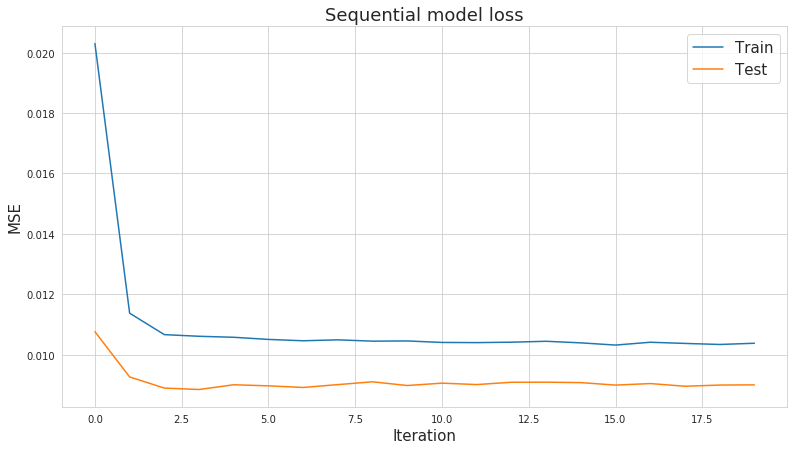

In [5]:
plt.figure(figsize=(13,7))
plt.plot(yfit.history['loss'])
plt.plot(yfit.history['val_loss'])
plt.title('Sequential model loss', fontsize=18)
plt.ylabel('MSE', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.legend(['Train', 'Test'], loc='upper right', fontsize=15)
plt.show()

### One hour predictions

Test RMSE: 0.611


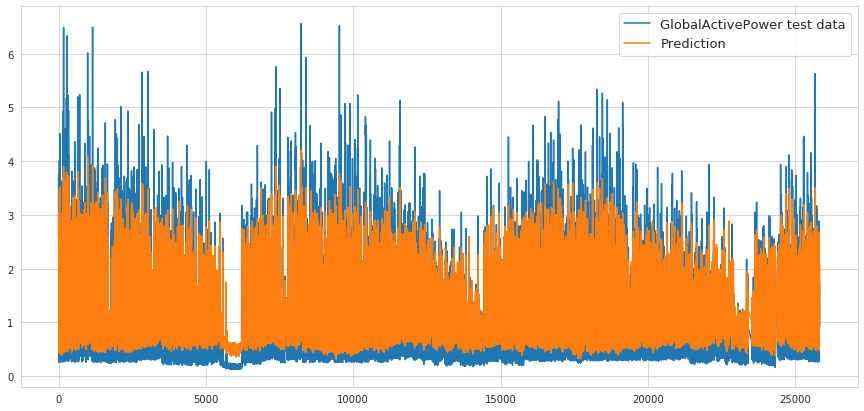

In [9]:
yhat = model.predict(test_X)
X_test = test_X.reshape((test_X.shape[0], 8))
X_test.shape

inv_yhat = np.concatenate((yhat, X_test[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, X_test[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize=(15,7))
x = np.arange(len(inv_y))
plt.plot(x,inv_y, label="GlobalActivePower test data")
plt.plot(x,inv_yhat, label="Prediction")
plt.legend(fontsize=13)
plt.show()